In [6]:
import scanpy as sc
import schist
import graph_tool.all as gt
from joblib import Parallel, delayed
import pandas as pd
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata = schist.io.read("10XV3")

In [3]:
def fast_min(state, beta, n_sweep, fast_tol):
    dS = 1
    while np.abs(dS) > fast_tol:
        dS, natt, nm = state.multiflip_mcmc_sweep(beta=beta, niter=n_sweep)
    return state, dS, natt, nm


In [4]:
g = adata.uns['schist']['state'].g

In [7]:
n_init = 3
states = [gt.PPBlockState(g) for x in range(n_init)]

beta = np.inf
tolerance = 1e-6
n_sweep = 10
states = Parallel(n_jobs=3, prefer='threads')(
            delayed(fast_min)(state, beta, n_sweep, tolerance) for state in states
        )
        
_amin = np.argmin([s[0].entropy() for s in states])            
state = states[_amin][0]
dS = states[_amin][1]
nattempts = states[_amin][2]
nmoves = states[_amin][3]

In [11]:
state.entropy()

pmode = gt.PartitionModeState([x[0].get_blocks().a for x in states], converge=True)

pv_array = pmode.get_marginal(g).get_2d_array(range(3)).T

bs = pmode.get_max(g)

gt.PPBlockState(g, b=bs).entropy()

import pandas as pd
adata.obs['ppbm1'] = pd.Categorical(state.get_blocks().a.astype(str))
adata.obs['ppbm2'] = pd.Categorical(bs.a.astype(str))

72535.66913155979

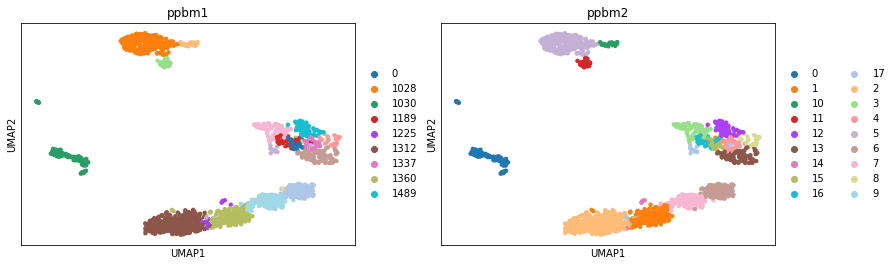

In [35]:
sc.pl.umap(adata, color=['ppbm1', 'ppbm2'])

In [36]:
n_init = 100
states = [gt.PPBlockState(g) for x in range(n_init)]

beta = np.inf
tolerance = 1e-6
n_sweep = 10
states = Parallel(n_jobs=3, prefer='threads')(
            delayed(fast_min)(state, beta, n_sweep, tolerance) for state in states
        )
        
_amin = np.argmin([s[0].entropy() for s in states])            
state = states[_amin][0]
dS = states[_amin][1]
nattempts = states[_amin][2]
nmoves = states[_amin][3]

In [43]:
pmode = gt.PartitionModeState([x[0].get_blocks().a for x in states], converge=True)
pv_array = pmode.get_marginal(g).get_2d_array(range(100)).T
bs = pmode.get_max(g)
print(gt.PPBlockState(g, b=bs).entropy(), state.entropy())

adata.obs['ppbm1'] = pd.Categorical(state.get_blocks().a.astype(str))
adata.obs['ppbm2'] = pd.Categorical(bs.a.astype(str))

72660.9912122434 72412.75185810152


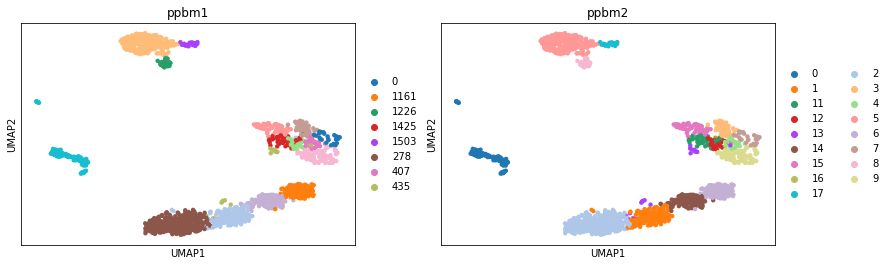

In [44]:
sc.pl.umap(adata, color=['ppbm1', 'ppbm2'])

In [45]:
adata.obs['max_ppbm_marginal'] = np.max(pv_array / 100, axis=1)

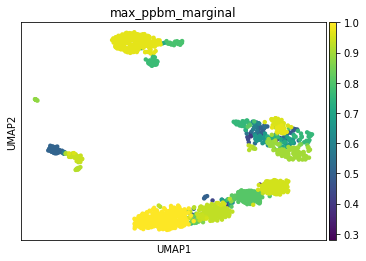

In [46]:
sc.pl.umap(adata, color='max_ppbm_marginal')

In [47]:
pv_array.shape

(1523, 100)

In [48]:
schist.inference.planted_model(adata)

In [49]:
schist.tl.max_marginal(adata)

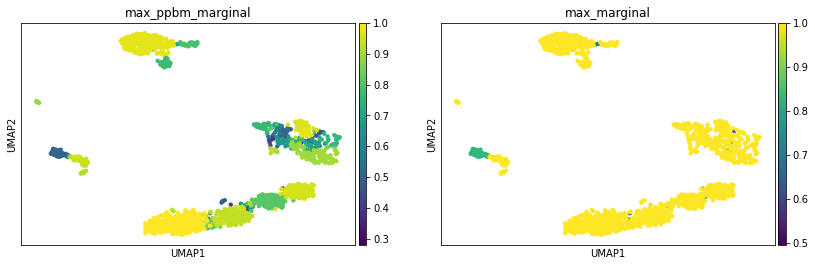

In [50]:
sc.pl.umap(adata, color=['max_ppbm_marginal', 'max_marginal'])

In [51]:
n_init = 100
states = [gt.NestedBlockState(g) for x in range(n_init)]

beta = np.inf
tolerance = 1e-6
n_sweep = 10
states = Parallel(n_jobs=3, prefer='threads')(
            delayed(fast_min)(state, beta, n_sweep, tolerance) for state in states
        )
        
_amin = np.argmin([s[0].entropy() for s in states])            
state = states[_amin][0]
dS = states[_amin][1]
nattempts = states[_amin][2]
nmoves = states[_amin][3]

In [52]:
state.entropy()

62472.811654249155

In [59]:
pmode = gt.PartitionModeState([x[0].get_bs() for x in states], converge=True, nested=True)

In [66]:
state = gt.NestedBlockState(g, bs=pmode.get_max_nested())

In [67]:
state.entropy()

63218.257608035805

In [72]:
np.unique(pmode.get_max(g).a)

PropertyArray([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15,
               16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
               32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47,
               48, 50, 51, 52, 53, 54, 57, 58, 60, 62, 65], dtype=int32)

In [74]:
np.unique(pmode.get_max_nested()[0])

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54,
       57, 58, 60, 62, 65], dtype=int32)

In [75]:
states = [x[0] for x in states]

In [97]:
pmode = gt.PartitionModeState([x.get_bs() for x in states], converge=True, nested=True)
state = gt.NestedBlockState(g, pmode.get_max_nested())

In [99]:
pv_array = []
for n in range(len(state.get_levels())):
    print(n)
    p = gt.PartitionModeState([x.project_partition(n, 0).a for x in states], converge=True)
    pv_array.append(p.get_marginal(g).get_2d_array(range(100)).T)

0
1
2
3
4
5
6
7
8
9
10
11


In [101]:
p0 = pmode.get_marginal(g).get_2d_array(range(100)).T

In [102]:
pv_array[0]

array([[86,  0,  0, ...,  0,  0,  0],
       [ 0, 90,  0, ...,  0,  0,  0],
       [ 0,  0, 35, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  3, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [103]:
p0

array([[86,  0,  0, ...,  0,  0,  0],
       [ 0, 90,  0, ...,  0,  0,  0],
       [ 0,  0, 35, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  3, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [104]:
schist._utils.plug_state(adata, state)

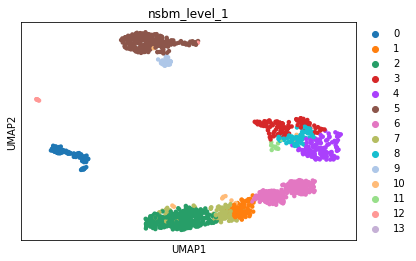

In [106]:
sc.pl.umap(adata, color='nsbm_level_1')

In [111]:
adata.obs['max_p2'] = np.max(pv_array[2], axis=1)/100

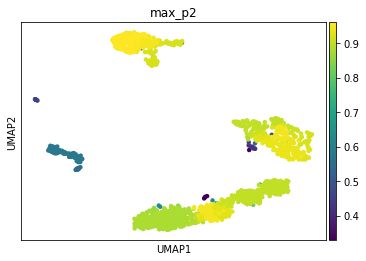

In [112]:
sc.pl.umap(adata, color='max_p2')

In [113]:
[x.shape for x in pv_array]

[(1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100),
 (1523, 100)]

In [119]:
p = gt.PartitionModeState([x.project_partition(2, 0).a for x in states], converge=True)

In [123]:
np.unique(p.get_max(g).a)

PropertyArray([1, 2, 3], dtype=int32)

In [125]:
state.get_levels()[2]

<BlockState object with 5 blocks (4 nonempty), for graph <Graph object, undirected, with 17 vertices and 64 edges, at 0x7fd629a32ee0>, at 0x7fd628c56f70>

In [128]:
gt.BlockState(g, b=p.get_max(g))

<BlockState object with 4 blocks (3 nonempty), degree-corrected, for graph <Graph object, undirected, with 1523 vertices and 21447 edges, 1 internal edge property, at 0x7fd6c34211f0>, at 0x7fd62acdff10>

In [142]:
bs = pmode.get_max_nested()
state = gt.NestedBlockState(g, bs)

In [143]:
samples = 100
pv_array = pmode.get_marginal(g).get_2d_array(range(len(np.unique(bs[0])))).T / samples

In [145]:
groups = np.zeros((g.num_vertices(), len(bs)), dtype=int)
for x in range(len(bs)):
    # for each level, project labels to the vertex level
    # so that every cell has a name. Note that at this level
    # the labels are not necessarily consecutive
    groups[:, x] = state.project_partition(x, 0).get_array()
groups = pd.DataFrame(groups).astype('category')

In [146]:
for c in groups.columns:
    ncat = len(groups[c].cat.categories)
    new_cat = [u'%s' % x for x in range(ncat)]
    groups[c].cat.rename_categories(new_cat, inplace=True)

levels = groups.columns


In [148]:
key_added = 'nsbm'
groups.columns = [f"{key_added}_level_{level}" for level in range(len(bs))]

In [157]:
ct = pd.crosstab(groups['nsbm_level_0'], groups['nsbm_level_2'], normalize='index')

In [ ]:
keep_columns = [x for x in adata.obs.columns if not x.startswith('%s_level_' % key_added)]
adata.obs = adata.obs[keep_columns]

In [170]:
groups.index = adata.obs_names

In [171]:
adata.obs = pd.concat([adata.obs, groups], axis=1)

In [172]:
adata.uns['schist'] = {}
adata.uns['schist']['stats'] = dict(
    level_entropy=np.array([state.level_entropy(x) for x in range(len(state.levels))]),
    modularity=np.array([gt.modularity(g, state.project_partition(x, 0))
                         for x in range(len((state.levels)))])
    )

adata.uns['schist']['state'] = state

    # now add marginal probabilities.


adata.obsm[f"CM_{key_added}_level_0"] = pv_array
for group in groups.columns[1:]:
    ct = pd.crosstab(groups[groups.columns[0]], groups[group], normalize='index')
    adata.obsm[f'CM_{group}'] = pv_array @ ct.values


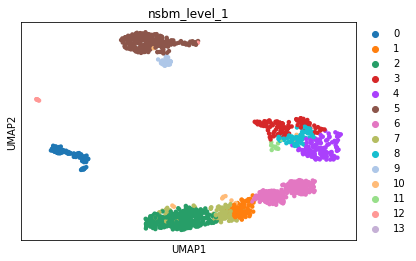

In [173]:
sc.pl.umap(adata, color='nsbm_level_1')

In [176]:
adata.obs['max_p2'] = np.max(adata.obsm['CM_nsbm_level_2'], axis=1)

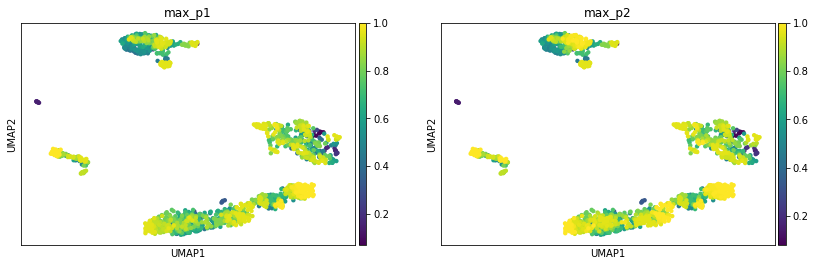

In [178]:
sc.pl.umap(adata, color=['max_p1', 'max_p2'])

In [181]:
adata.obs[['max_p1', 'max_p2']].diff(axis=1).sort_values('max_p2')

,max_p1,max_p2
10X2x5K_64221_AAACCTGCACTTCGAA,NaN,0.00
10X2x5K_64221_GAACGGAAGTAGCCGA,NaN,0.00
10X2x5K_64221_GAACGGATCCGAAGAG,NaN,0.00
10X2x5K_64221_GAAGCAGTCCATGAGT,NaN,0.00
10X2x5K_64221_GAATAAGCATCAGTCA,NaN,0.00
...,...,...
10X2x5K_64221_TGGGCGTTCAACACAC,NaN,0.44
10X2x5K_64221_TGCCCATGTGAAGGCT,NaN,0.45
10X2x5K_64221_AAGCCGCTCAGTTCGA,NaN,0.45
10X2x5K_64221_TATGCCCCATGCATGT,NaN,0.46
